In [1]:
import numpy as np
from astropy.io import fits # You might need to pip install this
import pylab as plt
import numpy as np
from matplotlib import pyplot as plt

Retrieve labels using this code that was given:

In [3]:
path_labels = "./labels.fits"
allstar = fits.open(path_labels)
labels = allstar[1].data
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
RGB_labels = labels[RGB]
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]

train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]


The features are given in npy file and are already split up in a way that matches the way the labels were split up

In [44]:
#ok so it looks like the data was p
train_features = np.load('./train_features.npy')
valid_features = np.load('./valid_features.npy')
test_features = np.load('./test_features.npy')
print(test_features.shape)
#n=1024
#p=8575

(512, 8575)


In [46]:
test_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 8575))

Method 1: Least squares. Step 1: normalize everything

Ok im just gonna rip some linnear algebra and hope it works

In [47]:

def normalize(x):
    mean=np.mean(x, axis=0)
    std=np.std(x,axis=0)
    std = np.where(std == 0, 1.0, std)
    # I was having issues where for some frequencies, the magnitude is just zero for all the training data. Then the variance for that frequency is zero, and obviously dividing by zero is bad
    # I asked chat gpt and it gave me this function above to set the variance to 1 for these scenarios.
    return((x-mean)/std)

#normalize train data
X_train=normalize(train_features)
Y_train=normalize(train_labels['LOGG']).reshape(-1,1)

#nnormalize validation data

X_valid=normalize(valid_features)
Y_valid=normalize(valid_labels['LOGG']).reshape(-1,1)

#normalize test

X_test=normalize(test_features)
Y_test=normalize(test_labels['LOGG']).reshape(-1,1)

# I want to solve the equation Ax=b in my case, A=X@X.T, and b= y. x is then equal to (x@x.T)^-1 @ y

psuedo_inverse_dot_Ytrain= X_train.T @ np.linalg.solve( X_train @ X_train.T , Y_train) 



# x_valid @ psuedo inverse dot y = y_valid?

model1= X_valid @ psuedo_inverse_dot_Ytrain
lstsq_err1= (Y_valid-model1)**2 




In [6]:
#ok I should add some regularization:

lam=[0,10,50,100,200,500,1000, 2000, 5000, 10000, 20000]

n= X_train.shape[0]

models=[]

for l in lam:
    A= X_train @ X_train.T + np.eye(n)*l

    psuedo_inverse_dot_Ytrain_regularized= X_train.T @ np.linalg.solve( A,Y_train )
    models.append(X_valid @ psuedo_inverse_dot_Ytrain_regularized)



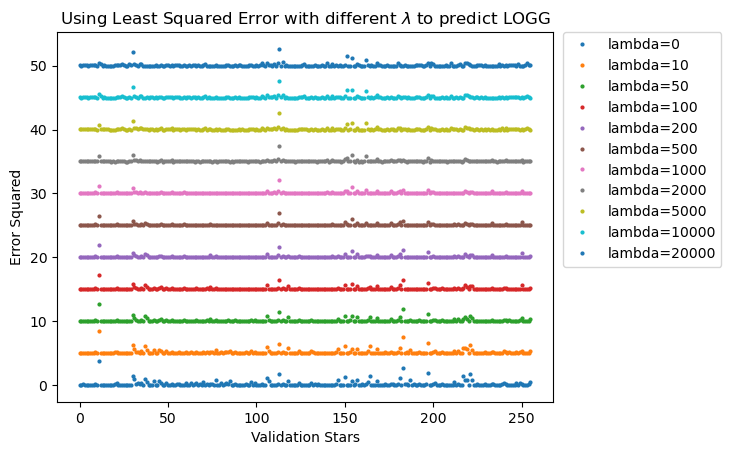

In [7]:
i=0
total_errs=[]
for model in models:
    lstsq_err_regularized=(model-Y_valid)**2
    total_errs.append(np.sum(lstsq_err_regularized))
    plt.plot( lstsq_err_regularized+i*5, 'o', markersize=2, label=f'lambda={lam[i]}')
    plt.xlabel('Validation Stars')
    plt.ylabel('Error Squared')
    i+=1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Using Least Squared Error with different $\lambda$ to predict LOGG')
plt.savefig('figs/lstsqr_err_vs_lambda.png')

21.05724150366799


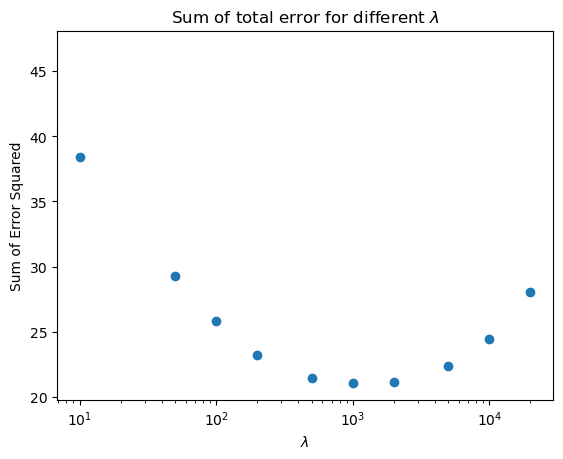

In [17]:
plt.scatter(lam,total_errs)
plt.title('Sum of total error for different $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Sum of Error Squared')
plt.semilogx()
plt.savefig('figs/lstsqr_total_err_vs_lambda.png')
print(min(total_errs))

The total error seems best for a regularization parameter of around 500 to 1,000. For lambda over 5,000 the fit appears worse.

Now its time for K nearest neighbors. So first have to define what makes two spectra "close"
the best measure of distance I can think of (spectra1-spectra2)**2. I asked chat gpt if there is a better way to do this than to measure the distance between every star in the training set and every star in the validation set, and it said: first normalize everything (which I did already), and also consider doing a PCA first. That way, instead of measuring a 8575 dimensional distance. you can measure a 100 dimensional distance. This seems reasonable... Also, it told me theres just a function from sci kit learn that outamatically does a KNN fit: 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [9]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor


In [21]:


neighbors=[1,2,4,8,16,32]


knn_predictions = []
knn_total_err = []

for k in neighbors:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, Y_train)
    
    y_pred = model.predict(X_valid)
    knn_err = np.sum((y_pred - Y_valid) ** 2)
    
    knn_predictions.append(y_pred)
    knn_total_err.append(knn_err)



[np.float32(37.517166), np.float32(25.732187), np.float32(25.03572), np.float32(26.074543), np.float32(30.951704), np.float32(38.157204)]


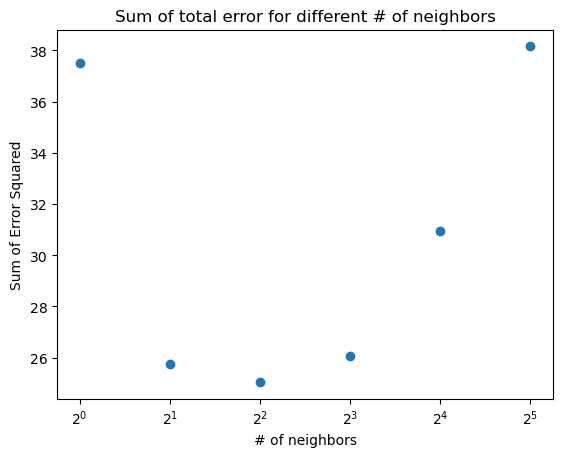

In [25]:
plt.scatter(neighbors,knn_total_err )
plt.title('Sum of total error for different # of neighbors')
plt.xlabel('# of neighbors')
plt.ylabel('Sum of Error Squared')
plt.xscale('log', base=2)
plt.savefig('figs/knn_err_vs_neighbors')
print(knn_total_err )

In [29]:
pca=PCA(n_components=100)

X_train_PCA=pca.fit_transform(X_train)

X_valid_PCA=pca.fit_transform(X_valid)

neighbors=[1,5,10,15,20,100]


pca_knn_predictions = []
pca_knn_total_err = []

for k in neighbors:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_PCA, Y_train)
    
    y_pred_pca = model.predict(X_valid_PCA)
    pca_knn_err = np.sum((y_pred_pca - Y_valid) ** 2)
    
    pca_knn_predictions.append(y_pred_pca)
    pca_knn_total_err.append(pca_knn_err)
    

[np.float32(70.68512), np.float32(64.587906), np.float32(62.576035), np.float32(63.55388), np.float32(64.17879), np.float32(65.11829)]


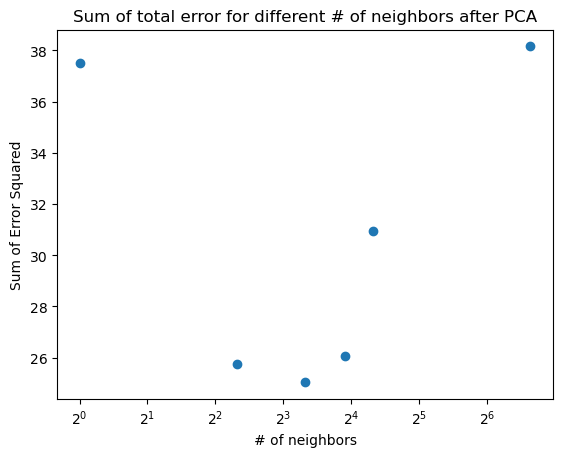

In [31]:
plt.scatter(neighbors,knn_total_err)
plt.title('Sum of total error for different # of neighbors after PCA')
plt.xlabel('# of neighbors')
plt.ylabel('Sum of Error Squared')
plt.xscale('log', base=2)
plt.savefig('figs/nearest_neighbors_after_PCA')
print(pca_knn_total_err)

The PCA with 100 components made the total error about twice as large and did not save a noticable amount of time. The nearest neighbor algorithm was fine without PCA. chatgpt you were wrong!

Time to try multilayer perceptron. I guess I just import MLP regressor from sci kit learn and go.

In [14]:
from sklearn.neural_network import MLPRegressor



def plot_err(model, title):
    prediction=model.predict(X_valid)
    err=(prediction.ravel()-Y_valid.ravel())**2
    plt.plot(err, 'bo')
    plt.xlabel('Star')
    plt.ylabel('Error Squared')
    print(model, ' The total loss with the validation set is', np.sum(err) )
    print('variance of error', np.var(err))
    plt.title(f'{title} ')
    plt.savefig(f'figs/{title}.png')



In [33]:
attempt1=MLPRegressor(hidden_layer_sizes=(256), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=200)
attempt1.fit(X_train, np.ravel(Y_train))


,loss,'squared_error'
,hidden_layer_sizes,256
,activation,'relu'
,solver,'adam'
,alpha,0.0003
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True


MLPRegressor(alpha=0.0003, hidden_layer_sizes=256, random_state=13)  The total loss with the validation set is 466.4143956879076
variance of error 21.55500787885083


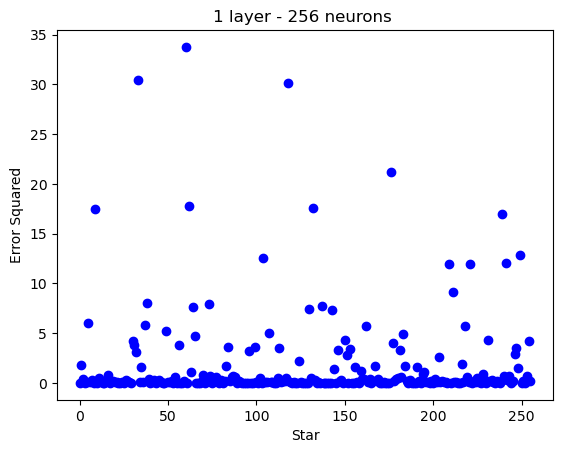

In [34]:
plot_err(attempt1,'1 layer - 256 neurons')

So far, least squares is winning. Lets try another 

In [35]:
attempt2=MLPRegressor(hidden_layer_sizes=(256,128), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=200)
attempt2.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0003
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True


MLPRegressor(alpha=0.0003, hidden_layer_sizes=(256, 128), random_state=13)  The total loss with the validation set is 102.13684349391278
variance of error 1.5328866790014248


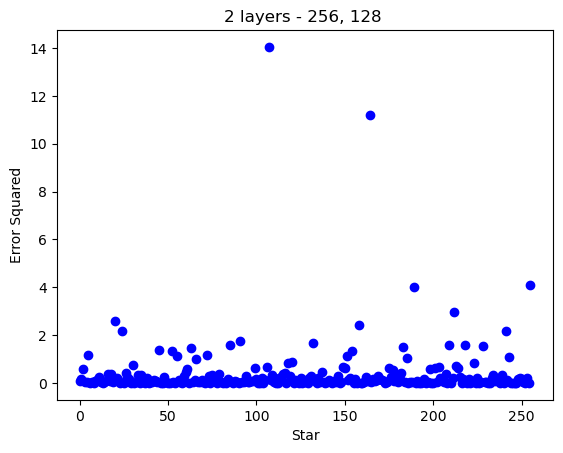

In [36]:
plot_err(attempt2, '2 layers - 256, 128')

In [66]:
attempt3=MLPRegressor(hidden_layer_sizes=(256,128,64,32), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=200)
attempt3.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0003
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True


MLPRegressor(alpha=0.0003, hidden_layer_sizes=(256, 128, 64, 32),
             random_state=13)  The total loss with the validation set is 25.2919078792672
variance of error 0.06314482425343523


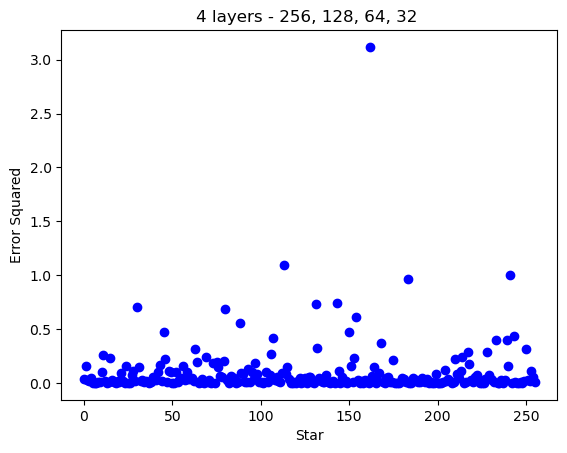

In [67]:
plot_err(attempt3, '4 layers - 256, 128, 64, 32')

In [ ]:
attempt4=MLPRegressor(hidden_layer_sizes=(64,32), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=200)

attempt4.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0003
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


MLPRegressor(alpha=0.0003, hidden_layer_sizes=(64, 32), max_iter=500,
             random_state=13)  The total loss with the validation set is 78.95135129688393
variance of error 0.3479347308192404


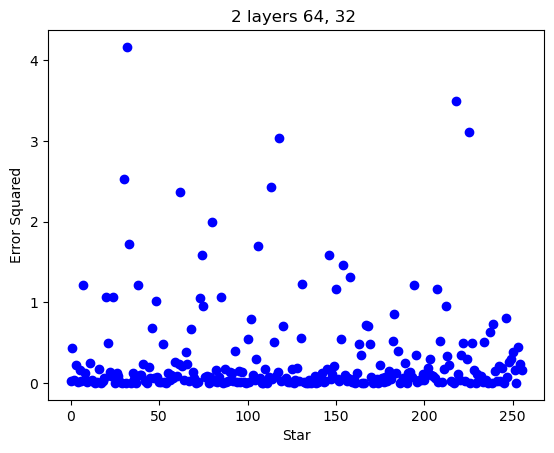

In [300]:
plot_err(attempt4,'2 layers 64, 32')

In [ ]:
attempt6=MLPRegressor(hidden_layer_sizes=(256,128,64,32,16,8,4,2), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=500)
attempt6.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


MLPRegressor(alpha=0.001, hidden_layer_sizes=(256, 128, 64, 32, 16, 8, 4, 2),
             max_iter=500, random_state=13)  The total loss with the validation set is 257.05398679141234
variance of error 1.3496772158078736


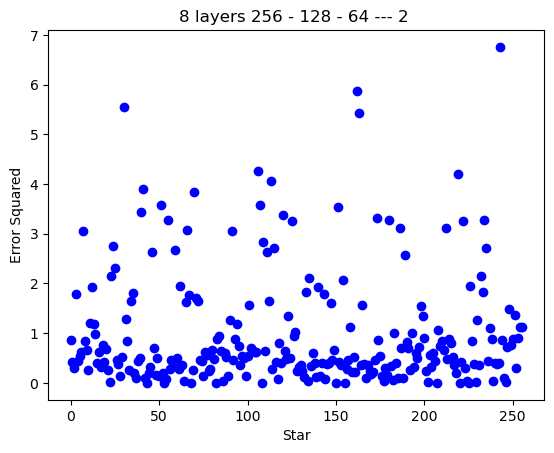

In [299]:
plot_err(attempt6, '8 layers 256 - 128 - 64 --- 2')

4 layers seems to be the best, I am going to now play around with a different activation function

In [ ]:
attempt_4layers_tanh=MLPRegressor(hidden_layer_sizes=(256,128,64,32), 
                  activation='tanh', 
                  solver='adam', 
                  random_state=13, 
                  alpha=1e-2, 
                  max_iter=500)
attempt_4layers_tanh.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.01
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


MLPRegressor(activation='tanh', alpha=0.01,
             hidden_layer_sizes=(256, 128, 64, 32), max_iter=500,
             random_state=13)  The total loss with the validation set is 26.17193221963253
variance of error 0.04165908834675587


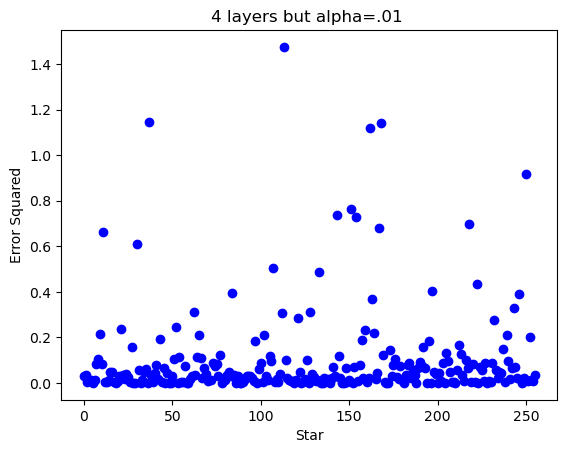

In [304]:
plot_err(attempt_4layers_tanh, '4 layers but alpha=.01')

In [305]:
attempt7=MLPRegressor(hidden_layer_sizes=(256,32), 
                  activation='relu', 
                  solver='adam', 
                  random_state=13, 
                  alpha=3e-4, 
                  max_iter=500)
attempt7.fit(X_train, np.ravel(Y_train))

,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0003
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


MLPRegressor(alpha=0.0003, hidden_layer_sizes=(256, 32), max_iter=500,
             random_state=13)  The total loss with the validation set is 85.48537067293039
variance of error 0.6472227218966404


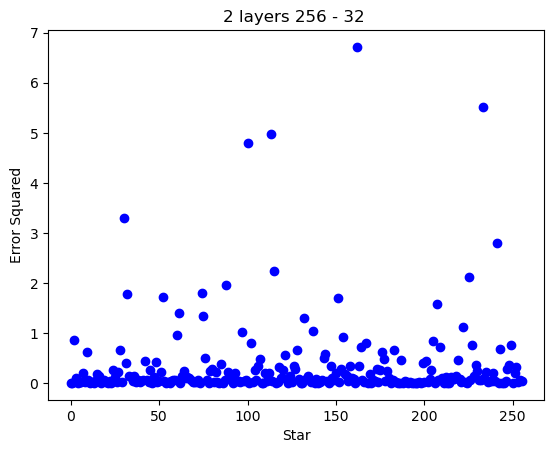

In [306]:
plot_err(attempt7,'2 layers 256 - 32')

In [40]:
random_seeds=[9,19,2,4,99]

for seed in random_seeds:
    attempt3=MLPRegressor(hidden_layer_sizes=(256,128,64,32), 
                    activation='relu', 
                    solver='adam', 
                    random_state=seed, 
                    alpha=3e-4, 
                    max_iter=200)

    attempt3.fit(X_train, np.ravel(Y_train))
    prediction=attempt3.predict(X_valid)
    err=np.sum((prediction.ravel()-Y_valid.ravel())**2)
    
    print(f'random seed is {seed} error is {err}')

random seed is 9 error is 26.78281822773923
random seed is 19 error is 23.865751368205487
random seed is 2 error is 25.654588186892315
random seed is 4 error is 28.950418229217433
random seed is 99 error is 27.566260041461035


Now I am going to pick the best hyperparameters from each of the models and run them on the test data. First lets try linnear regression with lambda=1000

In [51]:
#Linnear Regression
n= X_train.shape[0]
l=1000
A= X_train @ X_train.T + np.eye(n)*l

psuedo_inverse_dot_Ytrain_regularized= X_train.T @ np.linalg.solve( A,Y_train )
lstsq_1000=(X_test @ psuedo_inverse_dot_Ytrain_regularized)
lstsq_1000_err=np.sum( (Y_test-lstsq_1000)**2) 
print(lstsq_1000_err)

37.00580722200459


In [59]:
#KNN
model = KNeighborsRegressor(n_neighbors=8)
model.fit(X_train, Y_train)
    
y_pred = model.predict(X_test)
knn_err = np.sum((y_pred - Y_test) ** 2)
print(knn_err)

53.945824


In [70]:
#MLP
mlp_model=attempt3.predict(X_test)
mlp_error=(mlp_model-Y_test)**2
print(np.sum(mlp_error))

502017.9059077923


In [57]:
valid_features.shape

(256, 8575)

In [69]:
test_features.shape

(512, 8575)